In [1]:
%load_ext autoreload
%autoreload 2

import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from scipy.linalg import expm
from koopman.simulation.animation import PlotEnvironment
from koopman.simulation.systems import DynamicalSystem, NonlinearAttractor2D
from koopman.simulation.simulator import rk4_step
from IPython.display import HTML

def get_random_visible_color():
    # Sample hue randomly, fix saturation and value for vibrancy
    h = np.random.rand()           # Hue ∈ [0, 1]
    s = np.random.uniform(0.6, 1)  # Saturation: avoid pale colors
    v = np.random.uniform(0.7, 1)  # Value (brightness): avoid dark
    return mcolors.hsv_to_rgb((h, s, v))

# Vanilla Dynamics

In [8]:
# Constants
dt = 0.05     # timestep
tf = 10.0
N = int(tf / dt)  # number of timesteps
nx = NonlinearAttractor2D.nx
nu = NonlinearAttractor2D.nu

mu = 2.0
lam = -0.5

# Cost matrices
Q = np.diag([1.0, 0.1])        # State cost
R = np.diag([0.01])            # Control cost
Qf = 100 * Q                         # Terminal cost
x0_val = np.array([10.0, 8.0])
xf_val = np.array([0.0, 0.0])


def dynamics(x, u):
    x1 = x[0, 0]
    x2 = x[1, 0]
    
    x1_dot = -mu * x1
    x2_dot = -lam * (x2 - x1 ** 2) + u
    
    return ca.vertcat(x1_dot, x2_dot)

In [35]:
X = ca.MX.sym('X', nx, N + 1)
U = ca.MX.sym('U', nu, N)

cost = 0
ineq = []

ineq_dynamics = 0
ineq_state_constraint = 0

for k in range(N):
    xk = X[:, k]
    uk = U[:, k]
    xk_next = X[:, k+1]

    # Stage cost
    xkerr = xk - xf_val
    cost += ca.mtimes([xkerr.T, Q, xkerr])
    cost += ca.mtimes([uk.T, R, uk])

    # Dynamics constraint
    xk_next_pred = rk4_step(dynamics, xk, uk, dt)
    ineq.append(xk_next - xk_next_pred)
    
    ineq_dynamics += 1 * nx

# Terminal cost
xNerr = X[:, N] - xf_val
cost += ca.mtimes([xNerr.T, Qf, xNerr])

# Initial condition constraint
ineq.insert(0, X[:, 0] - x0_val)
ineq_dynamics += 1 * nx

# for k in range(N // 2):
#     xk = X[:, k]
#     ineq.append(xk - 2.0)
#     ineq_state_constraint += 1 * nx

ineq_flat = ca.vertcat(*ineq)

# Define decision variables
opt_vars = ca.vertcat(
    ca.reshape(X, nx * (N + 1), 1),
    ca.reshape(U, nu * N, 1)
)

# Create NLP
nlp = {'x': opt_vars, 'f': cost, 'g': ineq_flat}

# Solver
solver = ca.nlpsol('solver', 'ipopt', nlp,
                   {'ipopt.print_level': 0, 'print_time': 0})

# Initial guess
x0_guess = np.zeros((nx, N + 1))
u0_guess = np.random.randn(nu, N)
x0u0 = np.concatenate([x0_guess.flatten(), u0_guess.flatten()])

lbg_dynamics = np.zeros(ineq_dynamics)
ubg_dynamics = np.zeros(ineq_dynamics)
lbg_state_constraint = np.zeros(ineq_state_constraint)
ubg_state_constraint = ca.inf * np.ones(ineq_state_constraint)

lbg = ca.vertcat(
    lbg_dynamics,
    lbg_state_constraint
)

ubg = ca.vertcat(
    ubg_dynamics,
    ubg_state_constraint
)

# lbg = ubg = np.zeros(ineq_flat.shape)

x_min = -ca.inf * np.ones((nx, N + 1))
x_max = ca.inf * np.ones((nx, N + 1))
u_min = -2.0 * np.ones((nu, N))
u_max = 2.0 * np.ones((nu, N))

lbx = np.concatenate([x_min.flatten(), u_min.flatten()])
ubx = np.concatenate([x_max.flatten(), u_max.flatten()])

sol = solver(x0=x0u0, lbg=lbg, ubg=ubg, lbx=lbx, ubx=ubx)

stats = solver.stats()
print(f"Solver statistics:")
print(f"\titer_count: {stats['iter_count']}")
print(f"\treturn_status: {stats['return_status']}")

for k in stats:
    if k.startswith('t_'):
        print(f"\t{k}: {stats[k]}")

Solver statistics:
	iter_count: 22
	return_status: Solve_Succeeded
	t_proc_callback_fun: 0.0
	t_proc_nlp_f: 0.0009069999999999998
	t_proc_nlp_g: 0.0037199999999999998
	t_proc_nlp_grad: 0.0
	t_proc_nlp_grad_f: 0.00162
	t_proc_nlp_hess_l: 0.012059
	t_proc_nlp_jac_g: 0.012235
	t_wall_callback_fun: 0.0
	t_wall_nlp_f: 0.000917045
	t_wall_nlp_g: 0.003719996
	t_wall_nlp_grad: 0.0
	t_wall_nlp_grad_f: 0.0016333949999999995
	t_wall_nlp_hess_l: 0.012100452000000001
	t_wall_nlp_jac_g: 0.012286713


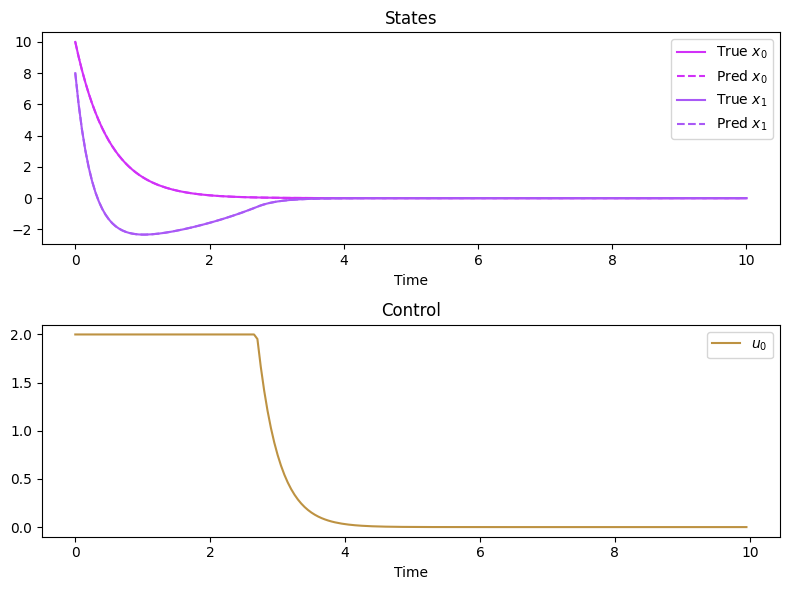

In [34]:
opt = sol['x'].full().flatten()
X_opt = opt[:nx*(N+1)].reshape((N+1, nx))
U_opt = opt[nx*(N+1):].reshape((N, nu))
eval_ts = np.arange(0, tf + dt, dt)

# Plot the results
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
for i in range(NonlinearAttractor2D.nx):
    color = get_random_visible_color()
    ax[0].plot(eval_ts, X_opt[:, i], color=color, label=fr"True $x_{i}$")
    ax[0].plot(eval_ts, X_opt[:, i], color=color, linestyle='--', label=fr"Pred $x_{i}$")
    
ax[0].set_title("States")
ax[0].set_xlabel("Time")
ax[0].legend()

for i in range(NonlinearAttractor2D.nu):
    color = get_random_visible_color()
    ax[1].plot(eval_ts[:-1], U_opt[:, i], color=color, label=rf"$u_{i}$")

ax[1].set_title("Control")
ax[1].set_xlabel("Time")
ax[1].legend()

plt.tight_layout()
plt.show()

# Koopman Dynamics

In [5]:
# Hand-pick the observables
def koopman_observables(xhist: np.ndarray) -> np.ndarray:
    is_batched = xhist.ndim == 2
    if not is_batched:
        xhist = np.expand_dims(xhist, axis=0)
    
    x1, x2 = xhist[:, 0], xhist[:, 1]
    
    Y = np.column_stack([
        x1 ** 2,
    ])
    
    out = np.concatenate([xhist, Y], axis=-1)
    
    if not is_batched:
        return np.squeeze(out, axis=0)
    else:
        return out
 
 
# Constants
dt = 0.05     # timestep
tf = 10.0
N = int(tf / dt)  # number of timesteps
nx = NonlinearAttractor2D.nx + 1
nu = NonlinearAttractor2D.nu
P = np.block([np.eye(NonlinearAttractor2D.nx), np.zeros((NonlinearAttractor2D.nx, nx - NonlinearAttractor2D.nx))])

mu = 2.0
lam = -0.5

# Cost matrices
Q = np.diag([1.0, 0.1])        # State cost
R = np.diag([0.01])            # Control cost
Qf = 100 * Q                         # Terminal cost

x0_val = np.array([10.0, 8.0])
x0_val = koopman_observables(x0_val)
xf_val = np.array([0.0, 0.0])
xf_val = koopman_observables(xf_val)

A = np.array([[ 9.04837500e-01, -1.84653183e-19,  1.73499148e-18],
       [-2.64816381e-17,  1.02531512e+00, -2.29538642e-02],
       [ 1.77369996e-16, -5.64613644e-16,  8.18730901e-01]])

B = np.array([[-6.55179985e-19],
       [ 5.06302409e-02],
       [ 3.88921530e-16]])

def discrete_dynamics(x, u):
    x_next = A @ x + B @ u
    return x_next

In [6]:
X = ca.MX.sym('X', nx, N + 1)
U = ca.MX.sym('U', nu, N)

cost = 0
ineq = []

for k in range(N):
    xk = X[:, k]
    uk = U[:, k]
    xk_next = X[:, k+1]

    # Stage cost
    xkerr = P @ (xk - xf_val)
    cost += ca.mtimes([xkerr.T, Q, xkerr])
    cost += ca.mtimes([uk.T, R, uk])

    # Dynamics constraint
    xk_next_pred = discrete_dynamics(xk, uk)
    ineq.append(xk_next - xk_next_pred)

# Terminal cost
xNerr = P @ (X[:, N] - xf_val)
cost += ca.mtimes([xNerr.T, Qf, xNerr])

# Initial condition constraint
ineq.insert(0, X[:, 0] - x0_val)

ineq_flat = ca.vertcat(*ineq)

# Define decision variables
opt_vars = ca.vertcat(
    ca.reshape(X, nx * (N + 1), 1),
    ca.reshape(U, nu * N, 1)
)

# Create NLP
nlp = {'x': opt_vars, 'f': cost, 'g': ineq_flat}

# Solver
solver = ca.nlpsol('solver', 'ipopt', nlp,
                   {'ipopt.print_level': 0, 'print_time': 0})

# Initial guess
x0_guess = np.zeros((nx, N + 1))
u0_guess = np.random.randn(nu, N)
x0u0 = np.concatenate([x0_guess.flatten(), u0_guess.flatten()])

lbg = ubg = np.zeros(ineq_flat.shape)

x_min = -ca.inf * np.ones((nx, N + 1))
x_max = ca.inf * np.ones((nx, N + 1))
u_min = -2.0 * np.ones((nu, N))
u_max = 2.0 * np.ones((nu, N))

lbx = np.concatenate([x_min.flatten(), u_min.flatten()])
ubx = np.concatenate([x_max.flatten(), u_max.flatten()])

sol = solver(x0=x0u0, lbg=lbg, ubg=ubg, lbx=lbx, ubx=ubx)

stats = solver.stats()
print(f"Solver statistics:")
print(f"\titer_count: {stats['iter_count']}")
print(f"\treturn_status: {stats['return_status']}")

for k in stats:
    if k.startswith('t_'):
        print(f"\t{k}: {stats[k]}")

Solver statistics:
	iter_count: 15
	return_status: Solve_Succeeded
	t_proc_callback_fun: 0.0
	t_proc_nlp_f: 0.000726
	t_proc_nlp_g: 0.000518
	t_proc_nlp_grad: 0.0
	t_proc_nlp_grad_f: 0.0014470000000000002
	t_proc_nlp_hess_l: 0.002811
	t_proc_nlp_jac_g: 0.001722
	t_wall_callback_fun: 0.0
	t_wall_nlp_f: 0.000730832
	t_wall_nlp_g: 0.000506607
	t_wall_nlp_grad: 0.0
	t_wall_nlp_grad_f: 0.001455313
	t_wall_nlp_hess_l: 0.002830245
	t_wall_nlp_jac_g: 0.0017366820000000002


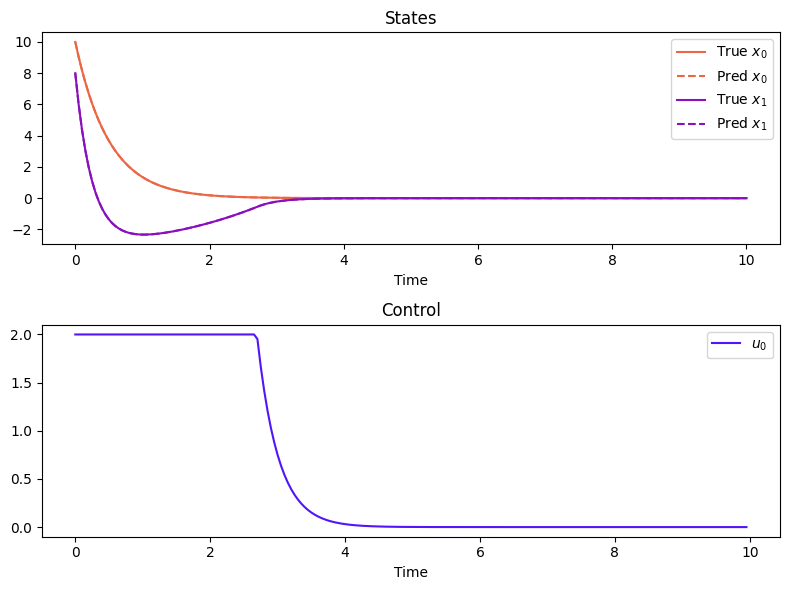

In [7]:
opt = sol['x'].full().flatten()
X_opt = opt[:nx*(N+1)].reshape((N+1, nx))
U_opt = opt[nx*(N+1):].reshape((N, nu))
eval_ts = np.arange(0, tf + dt, dt)

# Plot the results
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
for i in range(NonlinearAttractor2D.nx):
    color = get_random_visible_color()
    ax[0].plot(eval_ts, X_opt[:, i], color=color, label=fr"True $x_{i}$")
    ax[0].plot(eval_ts, X_opt[:, i], color=color, linestyle='--', label=fr"Pred $x_{i}$")
    
ax[0].set_title("States")
ax[0].set_xlabel("Time")
ax[0].legend()

for i in range(NonlinearAttractor2D.nu):
    color = get_random_visible_color()
    ax[1].plot(eval_ts[:-1], U_opt[:, i], color=color, label=rf"$u_{i}$")

ax[1].set_title("Control")
ax[1].set_xlabel("Time")
ax[1].legend()

plt.tight_layout()
plt.show()